# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import MinMaxScaler

# Deep learning libraries
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

# Reading The Data

In [3]:
data_dir = '../input/learn-time-series-forecasting-from-gold-price/gold_price_data.csv'
df = pd.read_csv(data_dir, index_col='Date', parse_dates=True)

# Data Exploration

In [4]:
df.head()

,Value
Date,
1970-01-01,35.2
1970-04-01,35.1
1970-07-01,35.4
1970-10-01,36.2
1971-01-01,37.4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10787 entries, 1970-01-01 to 2020-03-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   10787 non-null  float64
dtypes: float64(1)
memory usage: 168.5 KB


In [6]:
df.describe()

,Value
count,10787.000000
mean,653.596634
std,434.030848
min,35.100000
25%,349.200000
50%,409.350000
75%,1061.625000
max,1895.000000


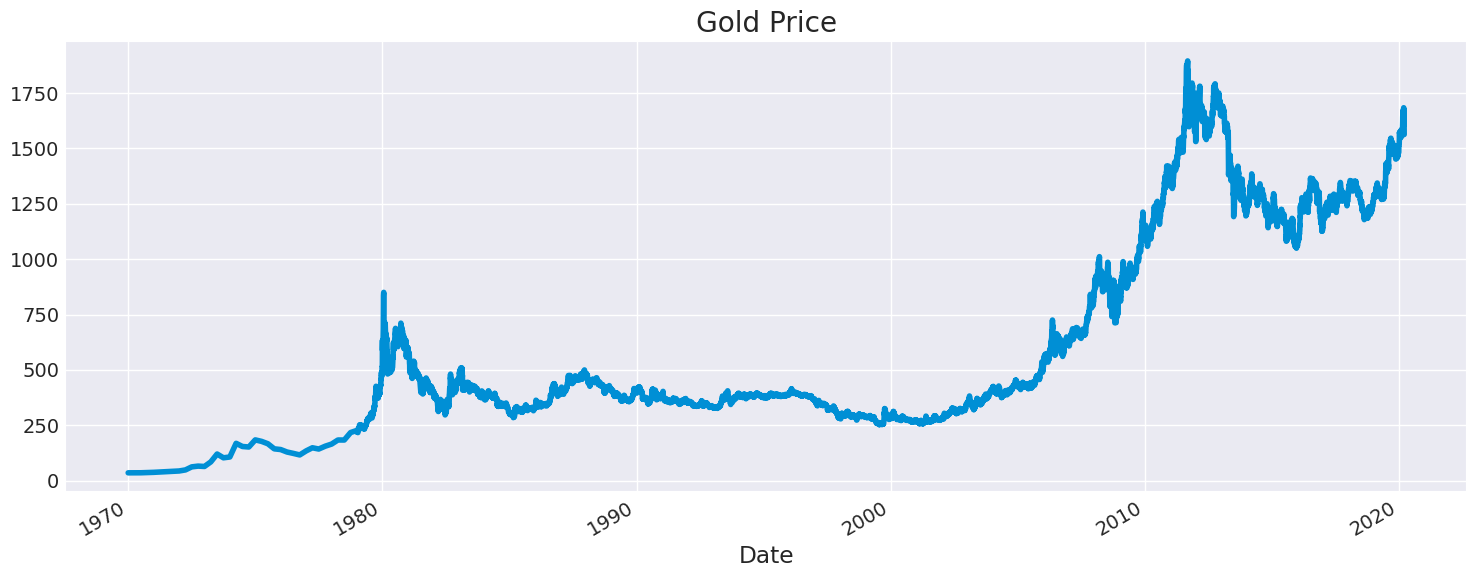

In [7]:
plt.figure(figsize=(15, 6))
df['Value'].plot()
plt.title("Gold Price")
plt.tight_layout()
plt.show()


# Data Preprocessing

## Choosing Prediction Column

In [9]:
data = df.values
data.shape

(10787, 1)

In [10]:
data

array([[  35.2 ],
       [  35.1 ],
       [  35.4 ],
       ...,
       [1653.75],
       [1570.7 ],
       [1562.8 ]])

## Normalizing Data

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

## Splitting The Data

In [12]:
# 75% to Train, 25% to Test
train_size = int(len(data) * .75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 8090 Test Size : 2697


In [13]:
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-60: , :]

In [14]:
train_data.shape, test_data.shape

((8090, 1), (2757, 1))

## Creating training set

In [15]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [16]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train  = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [18]:
x_train.shape , y_train.shape

((8030, 60, 1), (8030,))

# LSTM Model

## Model Structure

In [19]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1) ),
    LSTM(64, return_sequences=False),
    
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss= 'mse', metrics=['mean_absolute_error'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [21]:
early_stopping = EarlyStopping(
    patience=10,
    monitor='loss',
    restore_best_weights=True
)

In [22]:
# Fitting the LSTM to the Training set
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=early_stopping)

Epoch 1/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 0.0026 - mean_absolute_error: 0.0267
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - loss: 6.7957e-05 - mean_absolute_error: 0.0053
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 6.5019e-05 - mean_absolute_error: 0.0052
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - loss: 5.5489e-05 - mean_absolute_error: 0.0049
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - loss: 5.3423e-05 - mean_absolute_error: 0.0047
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 5.2740e-05 - mean_absolute_error: 0.0048
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 4.2033e-05 - mean_absolute_error: 0.0042
Epoch 8/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 3.9791e-05 - mean_absolute_error: 0.0042
Epoch 9/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 3.9842e-05 - mean_absolute_error: 0.0042
Epoch 10/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 3.41

## Model Evaluation

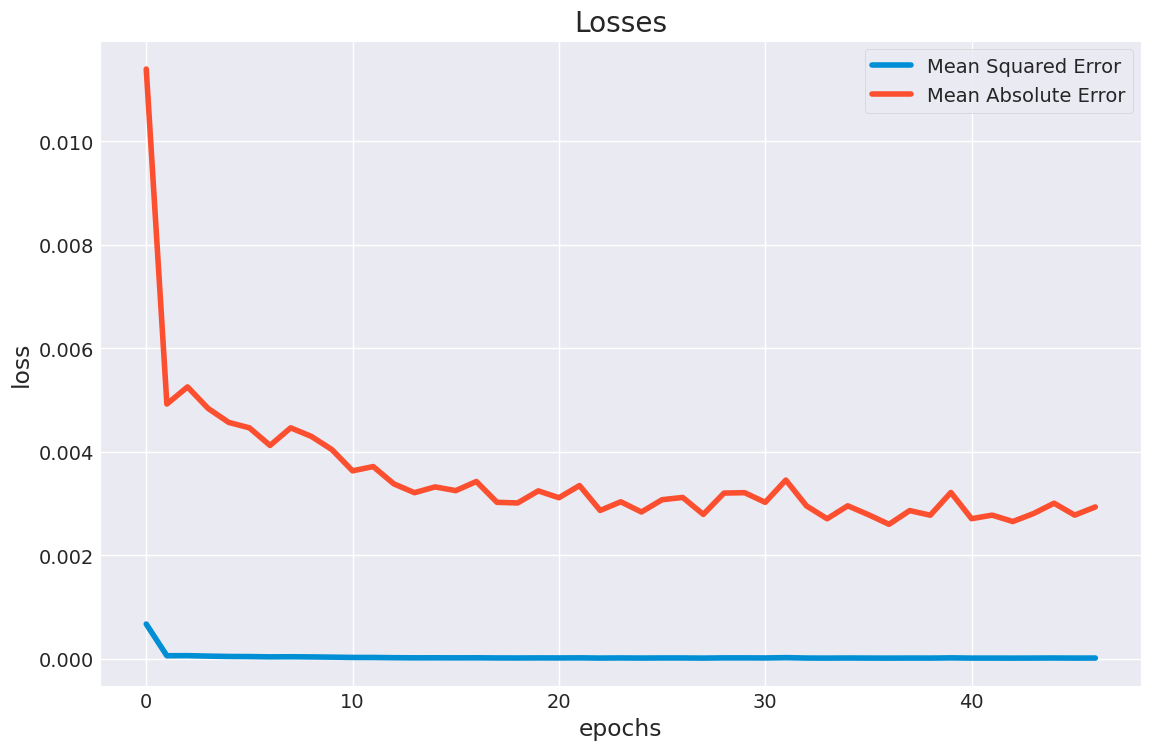

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Predection

## Creating testing set

In [24]:
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [25]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [26]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [27]:
x_test.shape , y_test.shape

((2697, 60, 1), (2697,))

In [28]:
# Get Prediction
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


(2697, 1)

## Root mean square error

In [29]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

27.27

In [30]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,1098.742432,1114.75
1,1097.454224,1104.00
2,1085.207520,1130.00
3,1114.877930,1134.75
4,1118.521851,1149.00
...,...,...
2692,1644.848877,1672.50
2693,1622.942749,1655.70
2694,1605.228027,1653.75
2695,1608.648315,1570.70


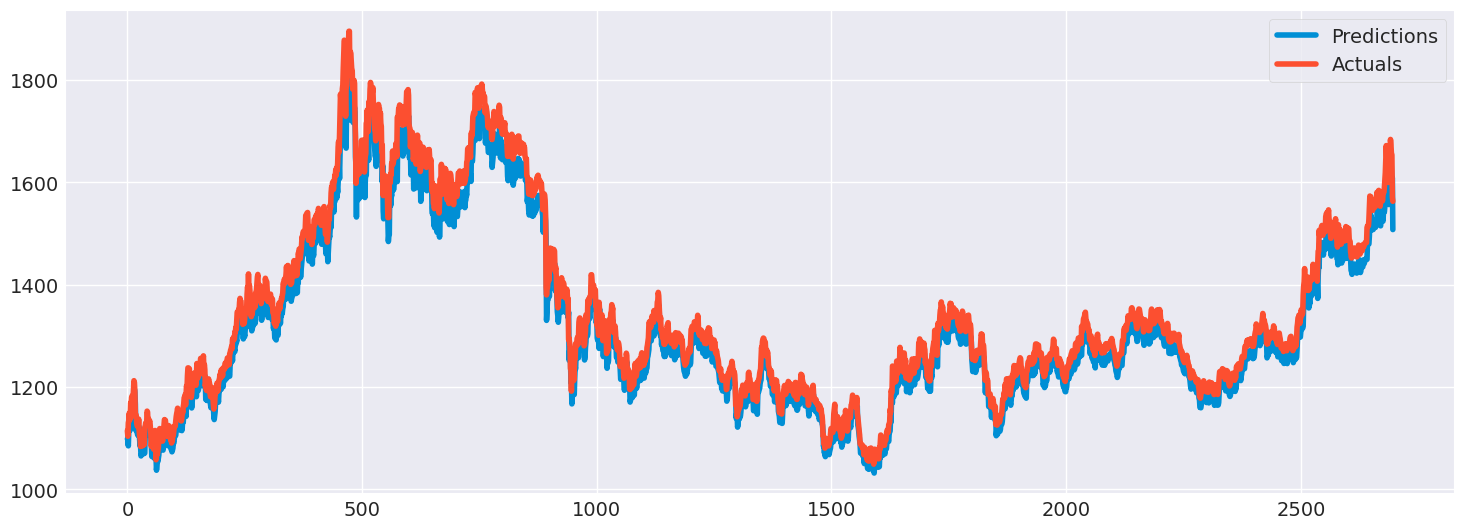

In [31]:
plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

## Visualize Predictions with The Data

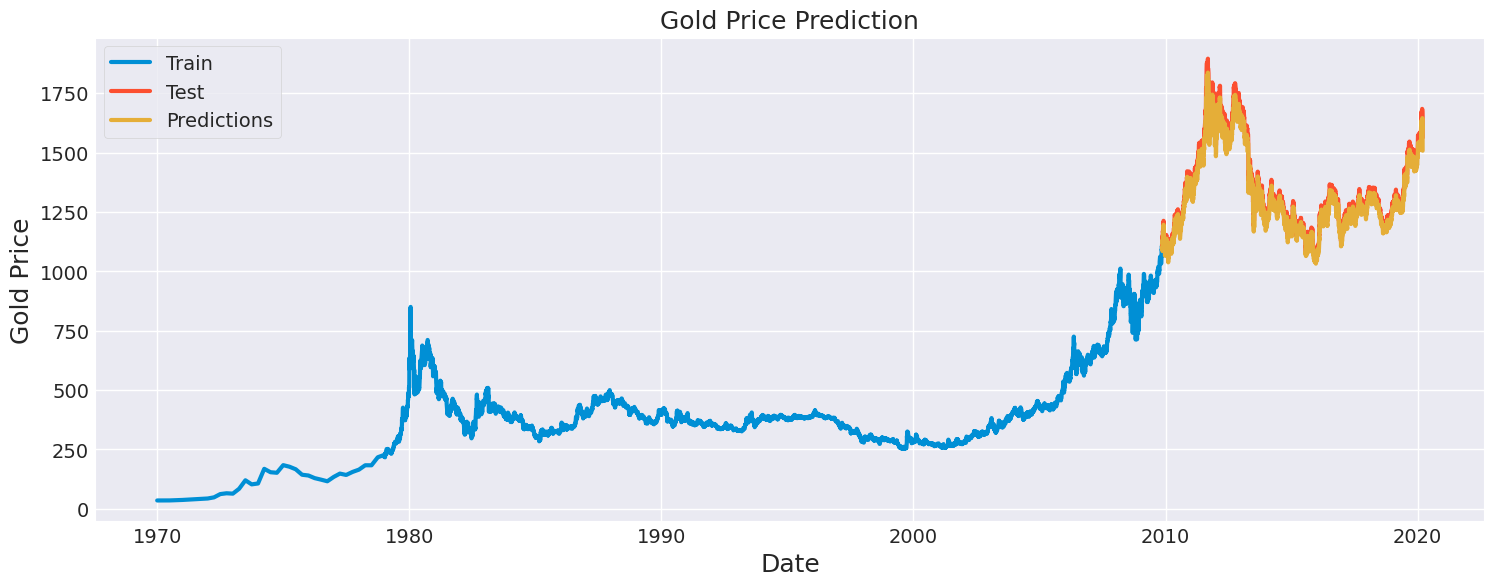

In [32]:
train = df.iloc[:train_size , 0:1]
test = df.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Gold Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Gold Price', fontsize= 18)
plt.plot(train['Value'], linewidth= 3)
plt.plot(test['Value'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])